In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
df = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

df.info()

Dataset loaded: 2,260,701 rows, 151 columns
Memory usage: 6353.39 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [6]:
print(df['loan_status'].value_counts())
print("\nProportions:")
print(df['loan_status'].value_counts(normalize=True))

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Proportions:
loan_status
Fully Paid                                             0.476298
Current                                                0.388521
Charged Off                                            0.118796
Late (31-120 days)                                     0.009496
In Grace Period                                        0.003732
Late (16-30 days)                                

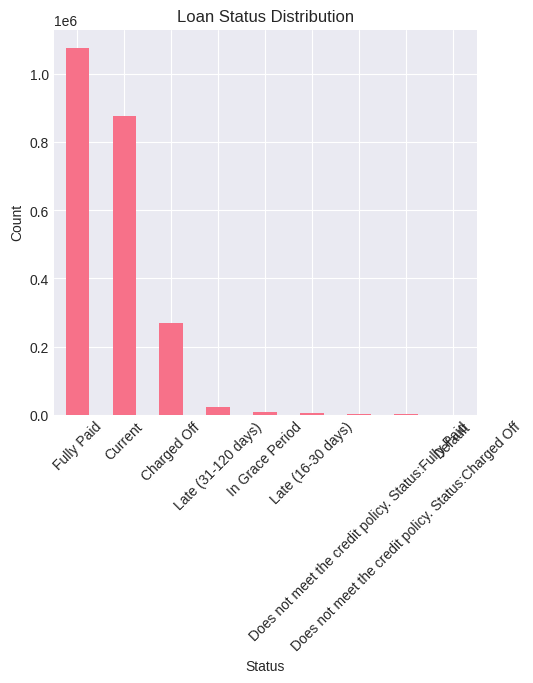

In [14]:
# Visualizing loan status
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)


status_groups = df['loan_status'].replace({
    'Fully Paid': 'Good',
    'Current': 'Current',
    'Charged Off': 'Bad',
    'Late (31-120 days)': 'Bad',
    'In Grace Period': 'Current',
    'Late (16-30 days)': 'Bad',
    'Default': 'Bad'
})


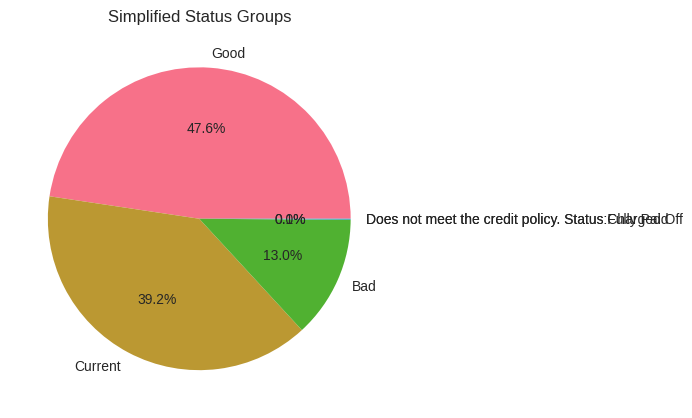

In [12]:
status_groups.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Simplified Status Groups')
plt.ylabel('')
plt.tight_layout()
plt.savefig('loan_status_distribution.png', dpi=300, bbox_inches='tight')
plt.show()



Columns with missing values: 150

Top 20 columns with most missing values:
                                         Column  Missing_Count  \
1                                     member_id        2260701   
140  orig_projected_additional_accrued_interest        2252050   
138                                hardship_dpd        2249784   
131                             hardship_status        2249784   
132                               deferral_term        2249784   
133                             hardship_amount        2249784   
134                         hardship_start_date        2249784   
135                           hardship_end_date        2249784   
136                     payment_plan_start_date        2249784   
137                             hardship_length        2249784   
139                        hardship_loan_status        2249784   
129                               hardship_type        2249784   
141              hardship_payoff_balance_amount        2249784   


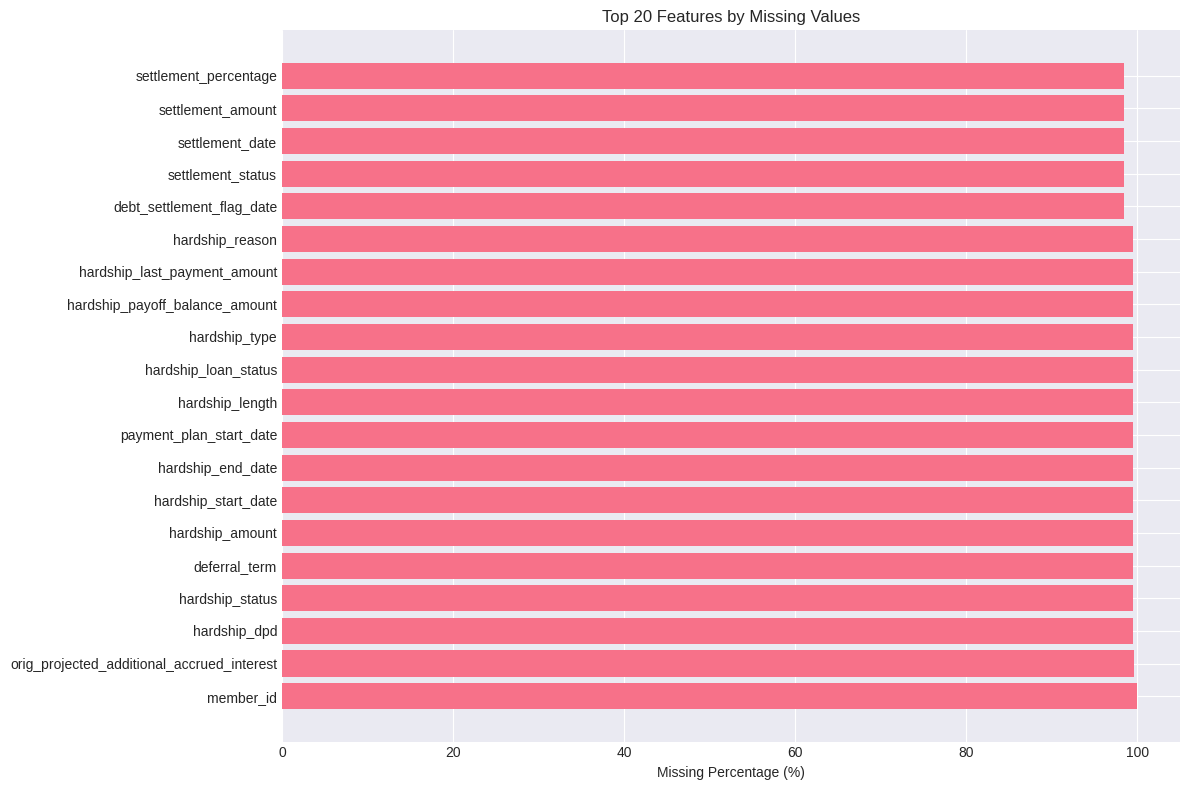

In [15]:
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"\nColumns with missing values: {len(missing_df)}")
print("\nTop 20 columns with most missing values:")
print(missing_df.head(20))

# Visualizing missing values
plt.figure(figsize=(12, 8))
top_missing = missing_df.head(20)
plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'])
plt.yticks(range(len(top_missing)), top_missing['Column'])
plt.xlabel('Missing Percentage (%)')
plt.title('Top 20 Features by Missing Values')
plt.tight_layout()
plt.savefig('missing_values.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
loan_features = [
    'loan_amnt',           # Loan amount
    'funded_amnt',         # Amount funded
    'term',                # Loan term (36 or 60 months)
    'int_rate',            # Interest rate
    'installment',         # Monthly payment
    'grade',               # LC assigned loan grade
    'sub_grade',           # LC assigned loan subgrade
]

borrower_financial = [
    'annual_inc',          # Annual income
    'dti',                 # Debt-to-income ratio
    'revol_bal',           # Revolving balance
    'revol_util',          # Revolving utilization rate
    'total_acc',           # Total credit lines
    'open_acc',            # Open credit lines
    'avg_cur_bal',         # Average current balance
    'bc_open_to_buy',      # Bankcard open to buy
    'bc_util',             # Bankcard utilization
    'tot_hi_cred_lim',     # Total high credit limit
]
credit_history = [
    'earliest_cr_line',    # Date of earliest credit line
    'delinq_2yrs',         # Delinquencies in past 2 years
    'inq_last_6mths',      # Inquiries in last 6 months
    'mths_since_last_delinq',  # Months since last delinquency
    'mths_since_last_record',  # Months since last public record
    'pub_rec',             # Number of public records
    'pub_rec_bankruptcies', # Number of bankruptcies
    'acc_open_past_24mths', # Accounts opened in past 24 months
]

categorical_features = [
    'home_ownership',      # Home ownership status
    'verification_status', # Income verification status
    'purpose',             # Loan purpose
    'addr_state',          # State
    'initial_list_status', # Initial listing status
    'application_type',    # Individual or joint application
]

employment_features = [
    'emp_length',          # Employment length
    'emp_title',           # Employment title (too many categories, may drop)
]

selected_features = (loan_features + borrower_financial + 
                    credit_history + categorical_features + 
                    employment_features)

print(f"Selected {len(selected_features)} features for modeling")
print("\nFeature categories:")
print(f"  - Loan characteristics: {len(loan_features)}")
print(f"  - Borrower financial: {len(borrower_financial)}")
print(f"  - Credit history: {len(credit_history)}")
print(f"  - Categorical: {len(categorical_features)}")
print(f"  - Employment: {len(employment_features)}")


Selected 33 features for modeling

Feature categories:
  - Loan characteristics: 7
  - Borrower financial: 10
  - Credit history: 8
  - Categorical: 6
  - Employment: 2


In [17]:
completed_statuses = ['Fully Paid', 'Charged Off', 'Default']
df_model = df[df['loan_status'].isin(completed_statuses)].copy()

print(f"Original dataset: {len(df):,} loans")
print(f"Completed loans only: {len(df_model):,} loans")
print(f"Reduction: {(1 - len(df_model)/len(df))*100:.1f}%")

df_model['target'] = (df_model['loan_status'].isin(['Charged Off', 'Default'])).astype(int)
print(f"\nTarget distribution:")
print(f"  Good loans (0): {(df_model['target']==0).sum():,} ({(df_model['target']==0).mean()*100:.1f}%)")
print(f"  Bad loans (1): {(df_model['target']==1).sum():,} ({(df_model['target']==1).mean()*100:.1f}%)")

available_features = [f for f in selected_features if f in df_model.columns]
missing_features = [f for f in selected_features if f not in df_model.columns]

print(f"\nAvailable features: {len(available_features)}/{len(selected_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Creating modeling dataset
df_modeling = df_model[available_features + ['target', 'loan_status']].copy()

Original dataset: 2,260,701 loans
Completed loans only: 1,345,350 loans
Reduction: 40.5%

Target distribution:
  Good loans (0): 1,076,751 (80.0%)
  Bad loans (1): 268,599 (20.0%)

Available features: 33/33


In [19]:
def preprocess_lending_club_data(df):
    """
    Comprehensive preprocessing for Lending Club data
    """
    df = df.copy()
    
    # Remove % signs and convert to float
    percent_cols = ['int_rate', 'revol_util']
    for col in percent_cols:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].str.rstrip('%').astype(float)
    
    # Convert term to numeric (remove "months")
    if 'term' in df.columns:
        df['term'] = df['term'].str.extract('(\d+)').astype(float)
    
    # Handle employment length
    if 'emp_length' in df.columns:
        emp_mapping = {
            '< 1 year': 0,
            '1 year': 1,
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10,
            'n/a': np.nan
        }
        df['emp_length'] = df['emp_length'].map(emp_mapping)
    
    # Convert earliest_cr_line to months of credit history
    if 'earliest_cr_line' in df.columns:
        df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')
        reference_date = pd.to_datetime('2018-12-31')  # End of dataset
        df['credit_history_months'] = ((reference_date - df['earliest_cr_line']).dt.days / 30.44).astype(float)
        df = df.drop('earliest_cr_line', axis=1)
    
    # Drop emp_title if present (too many categories)
    if 'emp_title' in df.columns:
        df = df.drop('emp_title', axis=1)
    
    return df

df_preprocessed = preprocess_lending_club_data(df_modeling)

In [20]:
numerical_cols = df_preprocessed.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c not in ['target']]

categorical_cols = df_preprocessed.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in ['loan_status']]

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Check missing values before imputation
print("\nMissing values before imputation:")
missing_before = df_preprocessed[numerical_cols + categorical_cols].isnull().sum()
print(missing_before[missing_before > 0])

# Impute numerical features with median
num_imputer = SimpleImputer(strategy='median')
df_preprocessed[numerical_cols] = num_imputer.fit_transform(df_preprocessed[numerical_cols])

# Impute categorical features with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df_preprocessed[categorical_cols] = cat_imputer.fit_transform(df_preprocessed[categorical_cols])

print("\nMissing values after imputation:")
print(df_preprocessed[numerical_cols + categorical_cols].isnull().sum().sum())

Numerical features: 24
Categorical features: 8

Missing values before imputation:
dti                           374
revol_util                    857
avg_cur_bal                 67549
bc_open_to_buy              61145
bc_util                     61914
tot_hi_cred_lim             67527
inq_last_6mths                  1
mths_since_last_delinq     678761
mths_since_last_record    1116786
pub_rec_bankruptcies          697
acc_open_past_24mths        47281
emp_length                  78516
dtype: int64

Missing values after imputation:
0


In [21]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_preprocessed[col] = le.fit_transform(df_preprocessed[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")


grade: 7 unique values
sub_grade: 35 unique values
home_ownership: 6 unique values
verification_status: 3 unique values
purpose: 14 unique values
addr_state: 51 unique values
initial_list_status: 2 unique values
application_type: 2 unique values



Numerical features summary:
          loan_amnt   funded_amnt          term      int_rate   installment  \
count  1.345350e+06  1.345350e+06  1.345350e+06  1.345350e+06  1.345350e+06   
mean   1.441997e+04  1.441155e+04  4.179029e+01  1.323971e+01  4.380756e+02   
std    8.717098e+03  8.713166e+03  1.026838e+01  4.768782e+00  2.615145e+02   
min    5.000000e+02  5.000000e+02  3.600000e+01  5.310000e+00  4.930000e+00   
25%    8.000000e+03  8.000000e+03  3.600000e+01  9.750000e+00  2.484800e+02   
50%    1.200000e+04  1.200000e+04  3.600000e+01  1.274000e+01  3.754300e+02   
75%    2.000000e+04  2.000000e+04  3.600000e+01  1.599000e+01  5.807300e+02   
max    4.000000e+04  4.000000e+04  6.000000e+01  3.099000e+01  1.719830e+03   

         annual_inc           dti     revol_bal    revol_util     total_acc  \
count  1.345350e+06  1.345350e+06  1.345350e+06  1.345350e+06  1.345350e+06   
mean   7.624757e+04  1.828245e+01  1.624796e+04  5.181003e+01  2.498075e+01   
std    6.992485e+04  1

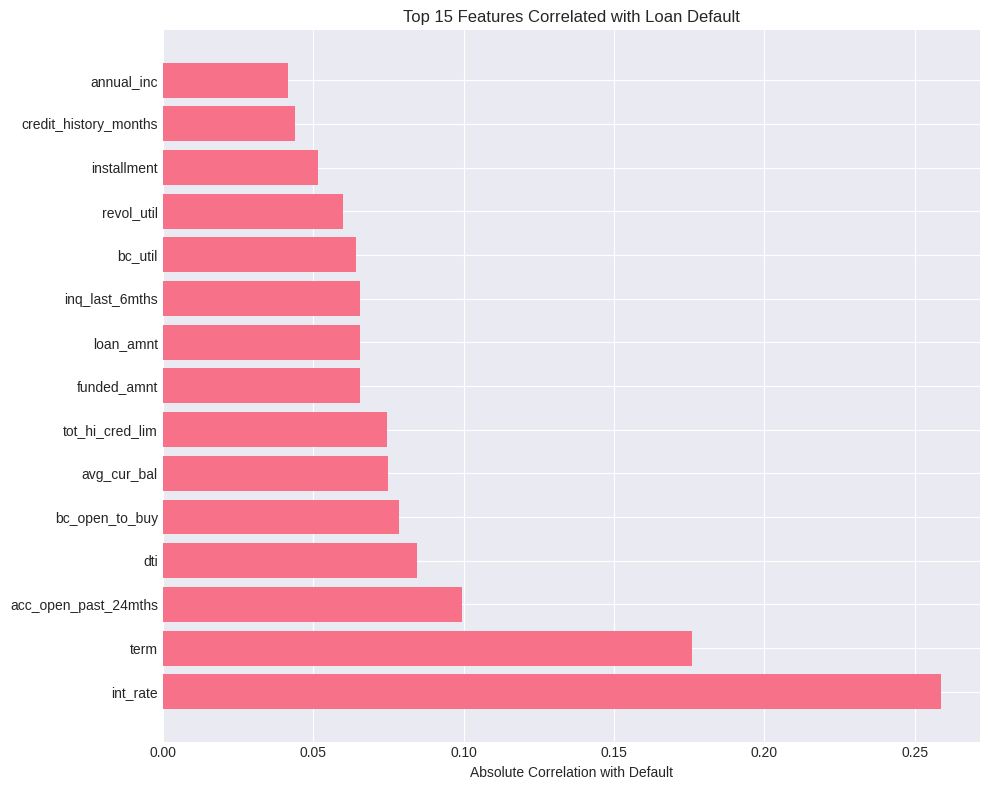

In [25]:
print("\nNumerical features summary:")
print(df_preprocessed[numerical_cols].describe())

# Correlations with target
print("\n FEATURE CORRELATIONS WITH DEFAULT ")
correlations = df_preprocessed[numerical_cols].corrwith(df_preprocessed['target']).sort_values(ascending=False)
print(correlations.head(15))

# Visualizing top correlations
plt.figure(figsize=(10, 8))
top_corr = correlations.abs().sort_values(ascending=False).head(15)
plt.barh(range(len(top_corr)), top_corr.values)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Absolute Correlation with Default')
plt.title('Top 15 Features Correlated with Loan Default')
plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()



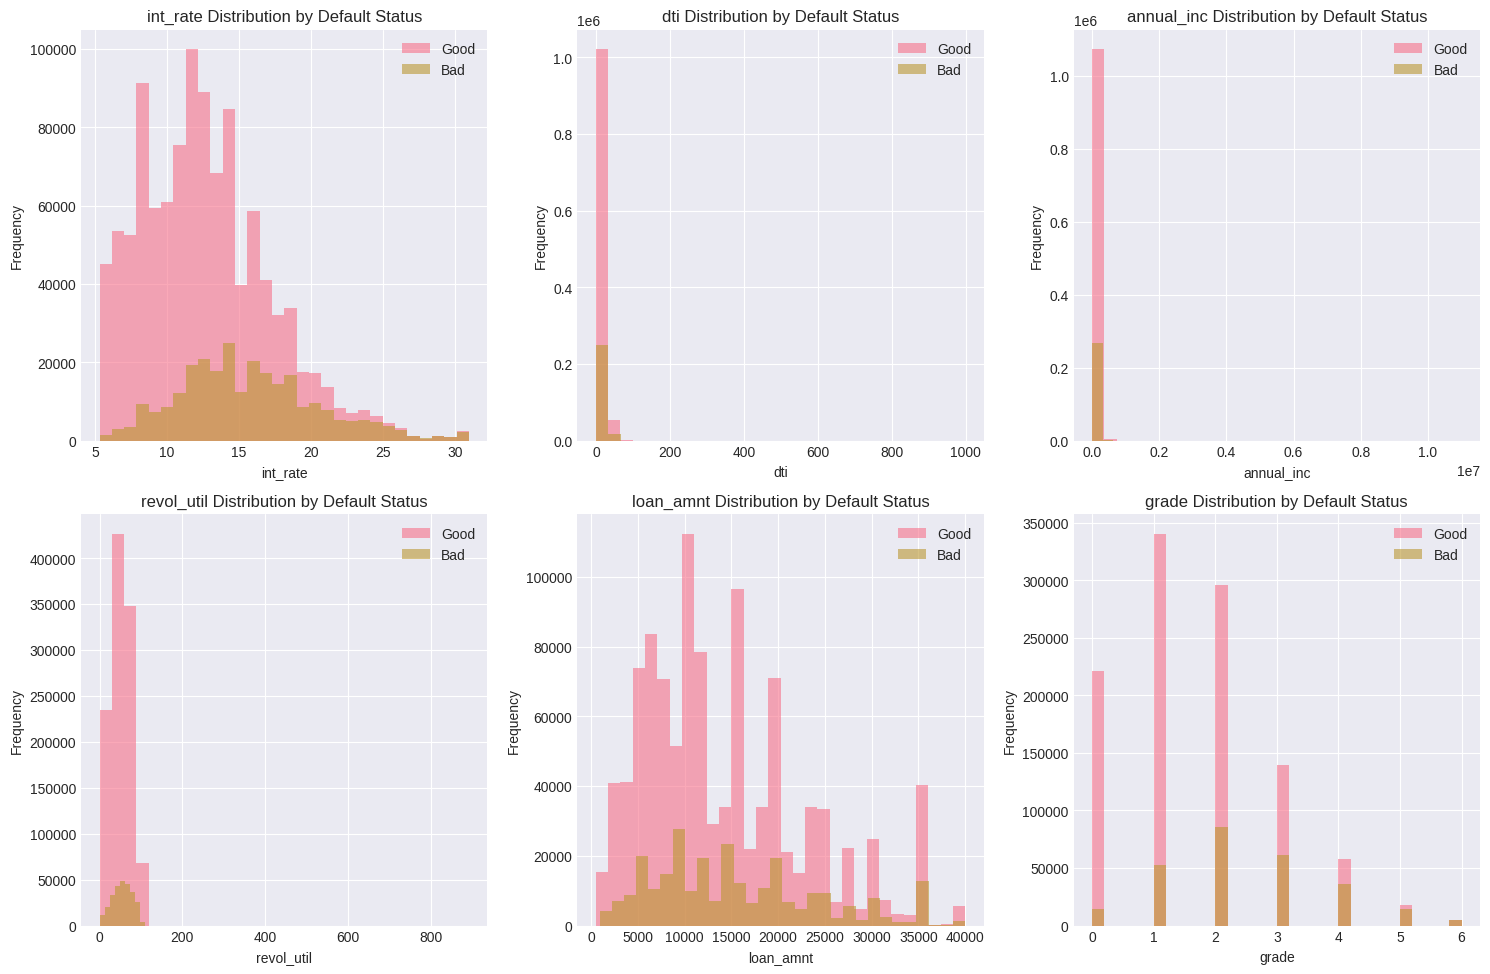

In [26]:
# Visualizing distributions of key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
key_features = ['int_rate', 'dti', 'annual_inc', 'revol_util', 'loan_amnt', 'grade']

for idx, feature in enumerate(key_features):
    if feature in df_preprocessed.columns:
        ax = axes[idx//3, idx%3]
        df_preprocessed.groupby('target')[feature].plot(kind='hist', alpha=0.6, ax=ax, bins=30, legend=True)
        ax.set_title(f'{feature} Distribution by Default Status')
        ax.set_xlabel(feature)
        ax.legend(['Good', 'Bad'])

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
X = df_preprocessed.drop(['target', 'loan_status'], axis=1)
y = df_preprocessed['target']

# Original data for RL rewards calculation
df_original = df_model.loc[df_preprocessed.index, ['loan_amnt', 'int_rate', 'loan_status', 'target']]

# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Data splits
df_train = df_original.loc[X_train.index]
df_val = df_original.loc[X_val.index]
df_test = df_original.loc[X_test.index]

print(f"Train set: {X_train.shape[0]:,} samples ({y_train.mean()*100:.2f}% default)")
print(f"Val set:   {X_val.shape[0]:,} samples ({y_val.mean()*100:.2f}% default)")
print(f"Test set:  {X_test.shape[0]:,} samples ({y_test.mean()*100:.2f}% default)")

Train set: 941,745 samples (19.96% default)
Val set:   201,802 samples (19.97% default)
Test set:  201,803 samples (19.97% default)


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed using StandardScaler")
print(f"Feature means (train, after scaling): {X_train_scaled.mean(axis=0)[:5]}")
print(f"Feature stds (train, after scaling): {X_train_scaled.std(axis=0)[:5]}")

Scaling completed using StandardScaler
Feature means (train, after scaling): [-7.42423960e-17  3.76040754e-17  6.80857095e-17 -6.79649901e-17
  1.79207865e-16]
Feature stds (train, after scaling): [1. 1. 1. 1. 1.]


In [30]:
import pickle

preprocessing_artifacts = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'X_train_scaled': X_train_scaled,
    'X_val_scaled': X_val_scaled,
    'X_test_scaled': X_test_scaled,
    'df_train': df_train,
    'df_val': df_val,
    'df_test': df_test,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_names': X.columns.tolist(),
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols
}

with open('preprocessing_artifacts.pkl', 'wb') as f:
    pickle.dump(preprocessing_artifacts, f)

print("Preprocessing artifacts saved to 'preprocessing_artifacts.pkl'")

print("\n" + "="*80)
print("PREPROCESSING COMPLETE!")
print("="*80)
print(f"Final feature set: {len(X.columns)} features")
print(f"Total samples: {len(X):,}")
print(f"Ready for model training!")
print("="*80)

Preprocessing artifacts saved to 'preprocessing_artifacts.pkl'

PREPROCESSING COMPLETE!
Final feature set: 32 features
Total samples: 1,345,350
Ready for model training!


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, 
                             recall_score, classification_report, 
                             confusion_matrix, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
print("Loading preprocessed data...")
with open('preprocessing_artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

X_train_scaled = artifacts['X_train_scaled']
X_val_scaled = artifacts['X_val_scaled']
X_test_scaled = artifacts['X_test_scaled']
y_train = artifacts['y_train']
y_val = artifacts['y_val']
y_test = artifacts['y_test']
feature_names = artifacts['feature_names']

print(f"Loaded data: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")
print(f"Number of features: {X_train_scaled.shape[1]}")


Loading preprocessed data...
Loaded data: Train=941745, Val=201802, Test=201803
Number of features: 32


In [35]:
# MLP Architecture

class LoanDefaultMLP(nn.Module):
    """
    Multi-Layer Perceptron for loan default prediction
    
    Architecture:
    - Input layer: number of features
    - Hidden layers: Configurable with BatchNorm and Dropout
    - Output layer: Single neuron with sigmoid activation
    """
    
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super(LoanDefaultMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


def create_data_loaders(X_train, y_train, X_val, y_val, batch_size=512, use_weighted_sampling=True):
    """
    Create PyTorch data loaders with optional class balancing
    """
    # Convert to tensors
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train.values).unsqueeze(1)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val),
        torch.FloatTensor(y_val.values).unsqueeze(1)
    )
    
    # Create weighted sampler to handle class imbalance
    if use_weighted_sampling:
        class_counts = np.bincount(y_train.values)
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[y_train.values]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

train_loader, val_loader = create_data_loaders(
    X_train_scaled, y_train, X_val_scaled, y_val, 
    batch_size=512, use_weighted_sampling=True
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


Data loaders created:
  Train batches: 1840
  Val batches: 395


In [36]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, patience=10):
    """
    Train the deep learning model with early stopping
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nTraining on device: {device}")
    model.to(device)
    
    # Loss function with class weights for imbalanced data
    pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Use model without final sigmoid for BCEWithLogitsLoss
    model_for_training = nn.Sequential(*list(model.network.children())[:-1])
    model_for_training.to(device)
    
    optimizer = optim.Adam(model_for_training.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=3, factor=0.5, verbose=True
    )
    
    best_val_auc = 0
    patience_counter = 0
    history = {
        'train_loss': [], 'val_loss': [], 
        'val_auc': [], 'val_f1': [],
        'learning_rate': []
    }
    
    print("\nStarting training...")
    print("-" * 80)
    
    for epoch in range(epochs):
        # Training phase
        model_for_training.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model_for_training(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model_for_training.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model_for_training(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                
                # Apply sigmoid to get probabilities
                probs = torch.sigmoid(outputs)
                val_preds.extend(probs.cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Calculate metrics
        val_auc = roc_auc_score(val_targets, val_preds)
        val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
        val_f1 = f1_score(val_targets, val_preds_binary)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Learning rate scheduling
        scheduler.step(val_auc)
        
        # Early stopping and model checkpoint
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model_for_training.state_dict(), 'best_dl_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | "
                  f"Val AUC: {val_auc:.4f} | "
                  f"Val F1: {val_f1:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print("-" * 80)
    print(f"Training completed! Best validation AUC: {best_val_auc:.4f}")
    
    return history, model_for_training



MODEL ARCHITECTURE
LoanDefaultMLP(
  (network): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=32, out_features=1, bias=True)
    (17): Sigmoid()
  )
)

Total parameters: 52,673

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

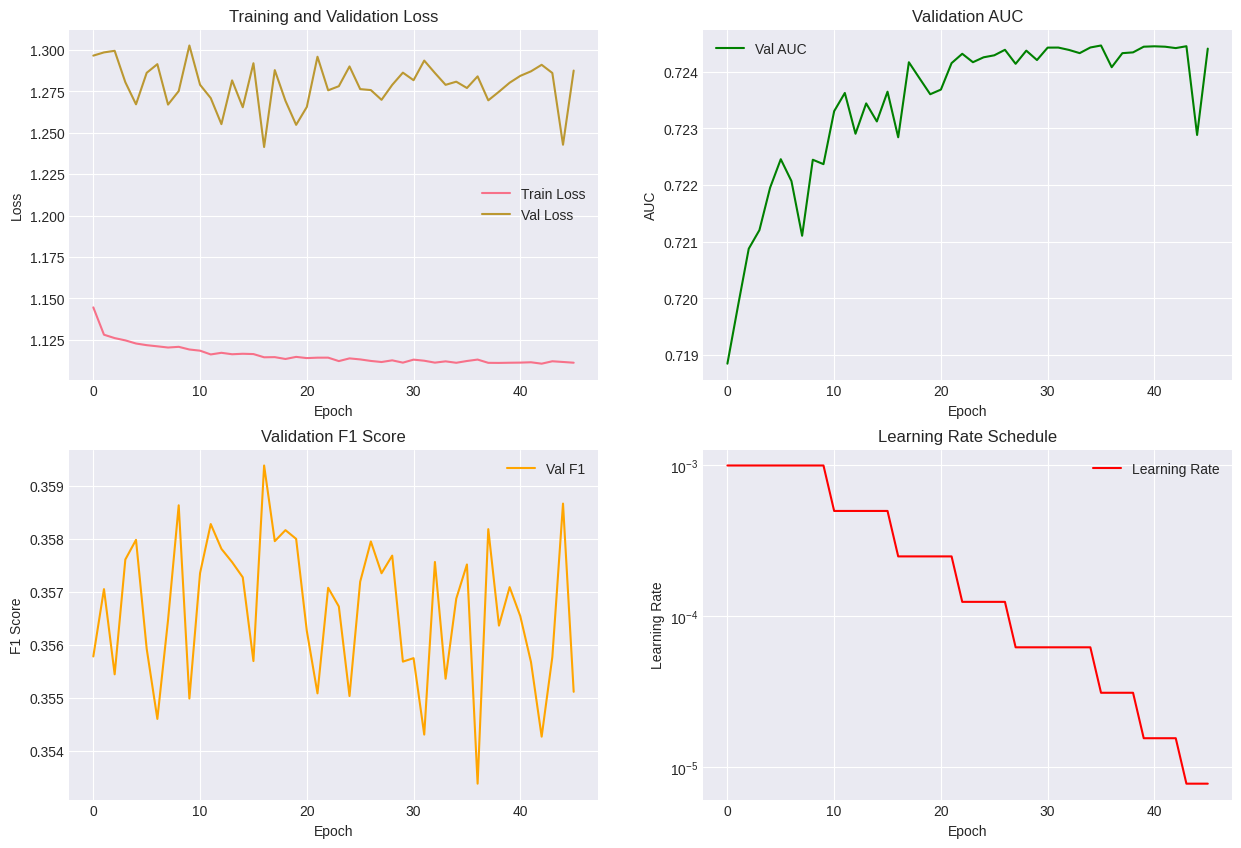

In [37]:
input_dim = X_train_scaled.shape[1]
model = LoanDefaultMLP(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64, 32],
    dropout=0.3
)

print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print("="*80)

# Train the model
history, trained_model = train_model(
    model, train_loader, val_loader,
    epochs=50, lr=0.001, patience=10
)

# ===========================
# 2.5 Visualize Training History
# ===========================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# AUC curve
axes[0, 1].plot(history['val_auc'], label='Val AUC', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 score curve
axes[1, 0].plot(history['val_f1'], label='Val F1', color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate
axes[1, 1].plot(history['learning_rate'], label='Learning Rate', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
with open('preprocessing_artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

X_train_scaled = artifacts['X_train_scaled']
X_val_scaled = artifacts['X_val_scaled']
X_test_scaled = artifacts['X_test_scaled']
y_train = artifacts['y_train']
y_val = artifacts['y_val']
y_test = artifacts['y_test']
df_train = artifacts['df_train']
df_val = artifacts['df_val']
df_test = artifacts['df_test']

print(f"Train: {len(y_train):,}, Val: {len(y_val):,}, Test: {len(y_test):,}")
print(f"Features: {X_train_scaled.shape[1]}")

Train: 941,745, Val: 201,802, Test: 201,803
Features: 32


In [45]:
def calculate_rewards(actions, loan_amounts, interest_rates, defaults):
    """Calculate rewards: Deny=0, Approve+Paid=interest, Approve+Default=-principal"""
    rewards = np.zeros(len(actions))
    for i in range(len(actions)):
        if actions[i] == 0:  # Deny
            rewards[i] = 0.0
        else:  # Approve
            loan_amnt = loan_amounts[i]
            int_rate = interest_rates[i] / 100.0
            if defaults[i] == 1:
                rewards[i] = -loan_amnt  # Loss
            else:
                rewards[i] = loan_amnt * int_rate  # Profit
    return rewards

print("\nReward Examples:")
print("-" * 80)
examples = [
    ("Deny loan", 0, 10000, 15.0, 0),
    ("Approve, Paid", 1, 10000, 15.0, 0),
    ("Approve, Default", 1, 10000, 15.0, 1),
]
for desc, act, loan, rate, dflt in examples:
    rew = calculate_rewards(np.array([act]), np.array([loan]), np.array([rate]), np.array([dflt]))[0]
    print(f"{desc:<20} Action={act} → Reward=${rew:,.0f}")
print("="*80)



Reward Examples:
--------------------------------------------------------------------------------
Deny loan            Action=0 → Reward=$0
Approve, Paid        Action=1 → Reward=$1,500
Approve, Default     Action=1 → Reward=$-10,000


In [46]:
def prep_rl_data(X_scaled, df_orig, y_labels, name):
    n = len(X_scaled)
    obs = X_scaled.astype(np.float32)
    acts = np.ones(n, dtype=np.int32)  # All approved in history
    
    loans = df_orig['loan_amnt'].values
    rates = df_orig['int_rate'].values
    if rates.dtype == 'object':
        rates = pd.Series(rates).str.rstrip('%').astype(float).values
    dflts = y_labels.values
    
    rews = calculate_rewards(acts, loans, rates, dflts).astype(np.float32)
    
    print(f"\n{name} SET:")
    print(f"  Samples: {n:,}")
    print(f"  Default rate: {dflts.mean()*100:.2f}%")
    print(f"  Reward - Mean: ${rews.mean():,.0f}, Total: ${rews.sum():,.0f}")
    
    return obs, acts, rews, loans, rates, dflts

obs_train, act_train, rew_train, loan_train, rate_train, def_train = prep_rl_data(
    X_train_scaled, df_train, y_train, "TRAIN")
obs_val, act_val, rew_val, loan_val, rate_val, def_val = prep_rl_data(
    X_val_scaled, df_val, y_val, "VAL")
obs_test, act_test, rew_test, loan_test, rate_test, def_test = prep_rl_data(
    X_test_scaled, df_test, y_test, "TEST")



TRAIN SET:
  Samples: 941,745
  Default rate: 19.96%
  Reward - Mean: $-1,644, Total: $-1,548,448,000

VAL SET:
  Samples: 201,802
  Default rate: 19.97%
  Reward - Mean: $-1,642, Total: $-331,381,696

TEST SET:
  Samples: 201,803
  Default rate: 19.97%
  Reward - Mean: $-1,652, Total: $-333,448,000


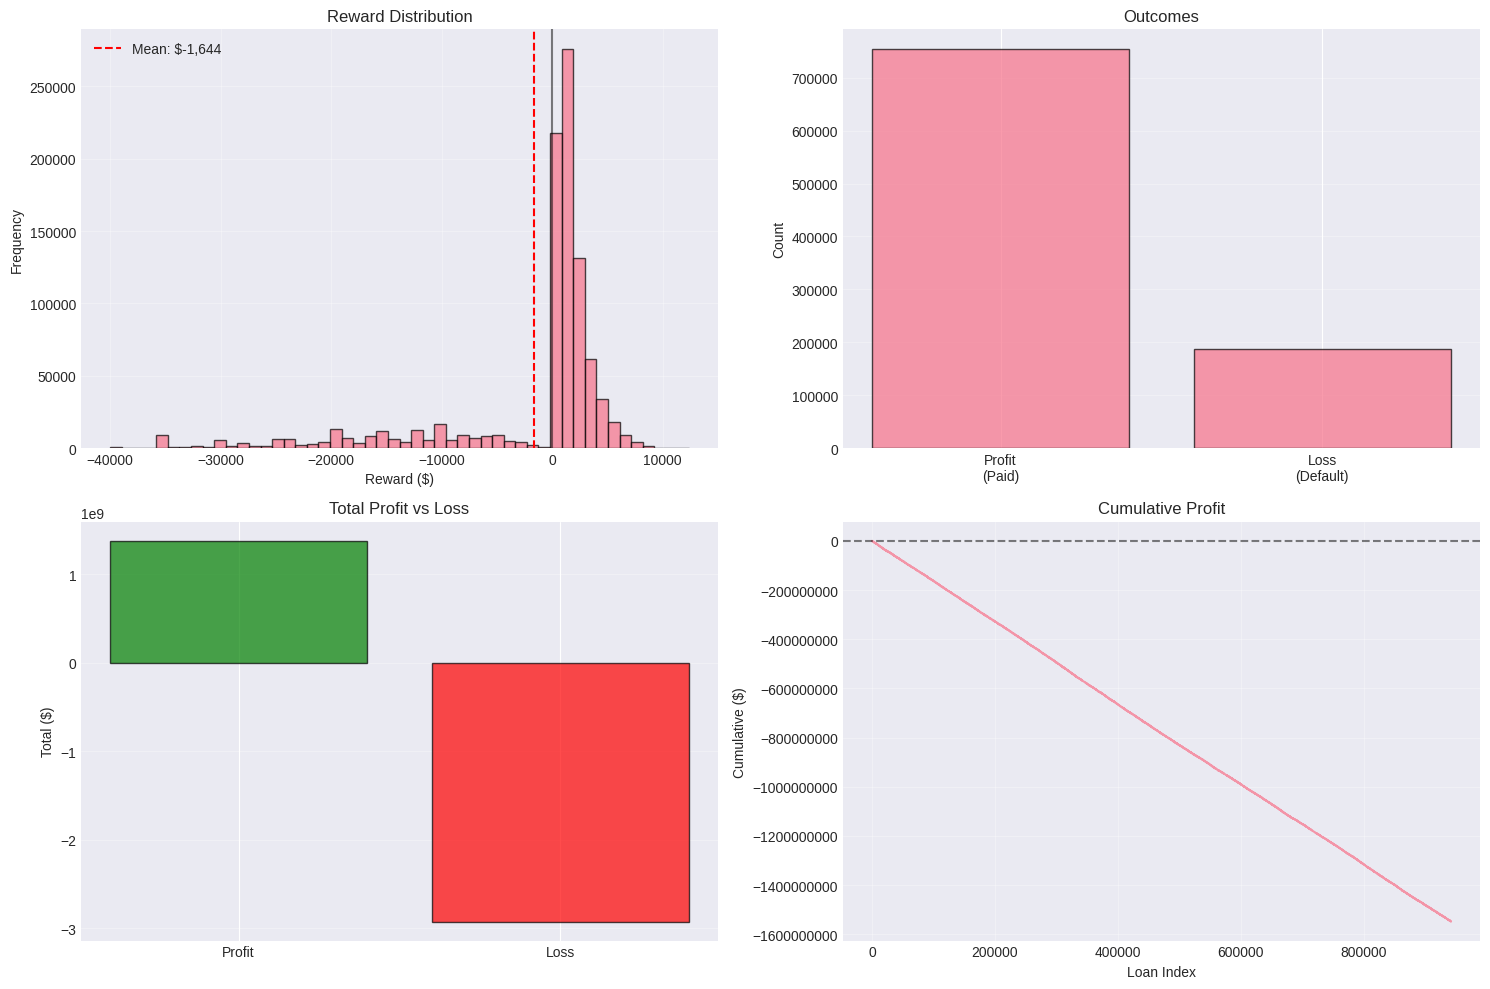

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(rew_train, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(rew_train.mean(), color='red', linestyle='--', label=f'Mean: ${rew_train.mean():,.0f}')
axes[0, 0].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[0, 0].set_xlabel('Reward ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Reward Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

pos_count = len(rew_train[rew_train > 0])
neg_count = len(rew_train[rew_train < 0])
axes[0, 1].bar(['Profit\n(Paid)', 'Loss\n(Default)'], [pos_count, neg_count], alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Outcomes')
axes[0, 1].grid(True, alpha=0.3, axis='y')

pos_total = rew_train[rew_train > 0].sum()
neg_total = rew_train[rew_train < 0].sum()
axes[1, 0].bar(['Profit', 'Loss'], [pos_total, neg_total], alpha=0.7, edgecolor='black', color=['green', 'red'])
axes[1, 0].set_ylabel('Total ($)')
axes[1, 0].set_title('Total Profit vs Loss')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].plot(np.cumsum(rew_train), alpha=0.7)
axes[1, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Loan Index')
axes[1, 1].set_ylabel('Cumulative ($)')
axes[1, 1].set_title('Cumulative Profit')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig('reward_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [49]:
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim=2, hidden_dims=[256, 128, 64]):
        super(DuelingQNetwork, self).__init__()
        
        layers = []
        prev = state_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev, h), nn.ReLU(), nn.Dropout(0.2)])
            prev = h
        self.features = nn.Sequential(*layers)
        
        self.value = nn.Sequential(nn.Linear(prev, 64), nn.ReLU(), nn.Linear(64, 1))
        self.advantage = nn.Sequential(nn.Linear(prev, 64), nn.ReLU(), nn.Linear(64, action_dim))
        
    def forward(self, state):
        feat = self.features(state)
        val = self.value(feat)
        adv = self.advantage(feat)
        q = val + (adv - adv.mean(dim=1, keepdim=True))
        return q

In [50]:

class CQLAgent:
    def __init__(self, state_dim, action_dim=2, lr=3e-4, gamma=0.99, alpha=1.0):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.action_dim = action_dim
        self.gamma = gamma
        self.alpha = alpha
        
        self.q_net = DuelingQNetwork(state_dim, action_dim).to(self.device)
        self.target_net = DuelingQNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        
        print(f"\nCQL Agent: state_dim={state_dim}, alpha={alpha}, gamma={gamma}, lr={lr}, device={self.device}")
    
    def predict(self, states):
        self.q_net.eval()
        with torch.no_grad():
            states_t = torch.FloatTensor(states).to(self.device)
            q_vals = self.q_net(states_t)
            actions = q_vals.argmax(dim=1).cpu().numpy()
        return actions
    
    def train_step(self, states, actions, rewards, next_states, dones):
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        curr_q_vals = self.q_net(states)
        curr_q = curr_q_vals.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_q_vals = self.q_net(next_states)
            next_acts = next_q_vals.argmax(dim=1)
            next_q_target = self.target_net(next_states)
            next_q = next_q_target.gather(1, next_acts.unsqueeze(1)).squeeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        bellman_loss = nn.functional.mse_loss(curr_q, target_q)
        
        q_logsumexp = torch.logsumexp(curr_q_vals, dim=1)
        cql_loss = (q_logsumexp - curr_q).mean()
        
        loss = bellman_loss + self.alpha * cql_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1.0)
        self.optimizer.step()
        
        return {
            'loss': loss.item(),
            'bellman': bellman_loss.item(),
            'cql': cql_loss.item(),
            'mean_q': curr_q.mean().item()
        }
    
    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

In [51]:
print("TRAINING CQL AGENT")
print("="*80)

agent = CQLAgent(state_dim=obs_train.shape[1], lr=3e-4, gamma=0.99, alpha=2.0)

batch_size = 512
n_epochs = 30
steps_per_epoch = len(obs_train) // batch_size
target_update_freq = 100

history = {'epoch': [], 'loss': [], 'bellman': [], 'cql': [], 'mean_q': [], 'val_profit': []}

print(f"\nEpochs: {n_epochs}, Batch: {batch_size}, Steps/epoch: {steps_per_epoch}\n")
print("-" * 80)

for epoch in range(n_epochs):
    metrics = {'loss': [], 'bellman': [], 'cql': [], 'mean_q': []}
    indices = np.random.permutation(len(obs_train))
    
    for step in range(steps_per_epoch):
        idx = indices[step*batch_size:(step+1)*batch_size]
        m = agent.train_step(obs_train[idx], act_train[idx], rew_train[idx], 
                             obs_train[idx], np.ones(len(idx)))
        for k in metrics:
            metrics[k].append(m[k])
        
        if (step + 1) % target_update_freq == 0:
            agent.update_target()
    
    val_acts = agent.predict(obs_val)
    val_rews = calculate_rewards(val_acts, loan_val, rate_val, def_val)
    val_profit = val_rews.sum()
    
    history['epoch'].append(epoch + 1)
    history['loss'].append(np.mean(metrics['loss']))
    history['bellman'].append(np.mean(metrics['bellman']))
    history['cql'].append(np.mean(metrics['cql']))
    history['mean_q'].append(np.mean(metrics['mean_q']))
    history['val_profit'].append(val_profit)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {history['loss'][-1]:8.2f} | "
              f"Bellman: {history['bellman'][-1]:8.2f} | CQL: {history['cql'][-1]:6.2f} | "
              f"Val Profit: ${val_profit:12,.0f}")

print("-" * 80)
print("Training complete!")

torch.save({'q_net': agent.q_net.state_dict(), 'history': history}, 'cql_agent.pt')
print("Model saved to 'cql_agent.pt'\n")

TRAINING CQL AGENT

CQL Agent: state_dim=32, alpha=2.0, gamma=0.99, lr=0.0003, device=cpu

Epochs: 30, Batch: 512, Steps/epoch: 1839

--------------------------------------------------------------------------------
Epoch   1/30 | Loss: 61086442.14 | Bellman: 61083895.04 | CQL: 1273.57 | Val Profit: $           0
Epoch   5/30 | Loss: 59107519.37 | Bellman: 59104711.43 | CQL: 1403.96 | Val Profit: $  12,337,999
Epoch  10/30 | Loss: 58832264.21 | Bellman: 58829452.87 | CQL: 1405.68 | Val Profit: $  10,123,825
Epoch  15/30 | Loss: 58647792.35 | Bellman: 58645055.18 | CQL: 1368.58 | Val Profit: $   9,678,994
Epoch  20/30 | Loss: 58493711.56 | Bellman: 58491061.65 | CQL: 1324.95 | Val Profit: $  10,258,770
Epoch  25/30 | Loss: 58340155.36 | Bellman: 58337573.36 | CQL: 1291.00 | Val Profit: $   7,576,665
Epoch  30/30 | Loss: 58237134.71 | Bellman: 58234600.76 | CQL: 1266.96 | Val Profit: $   4,477,546
--------------------------------------------------------------------------------
Training co

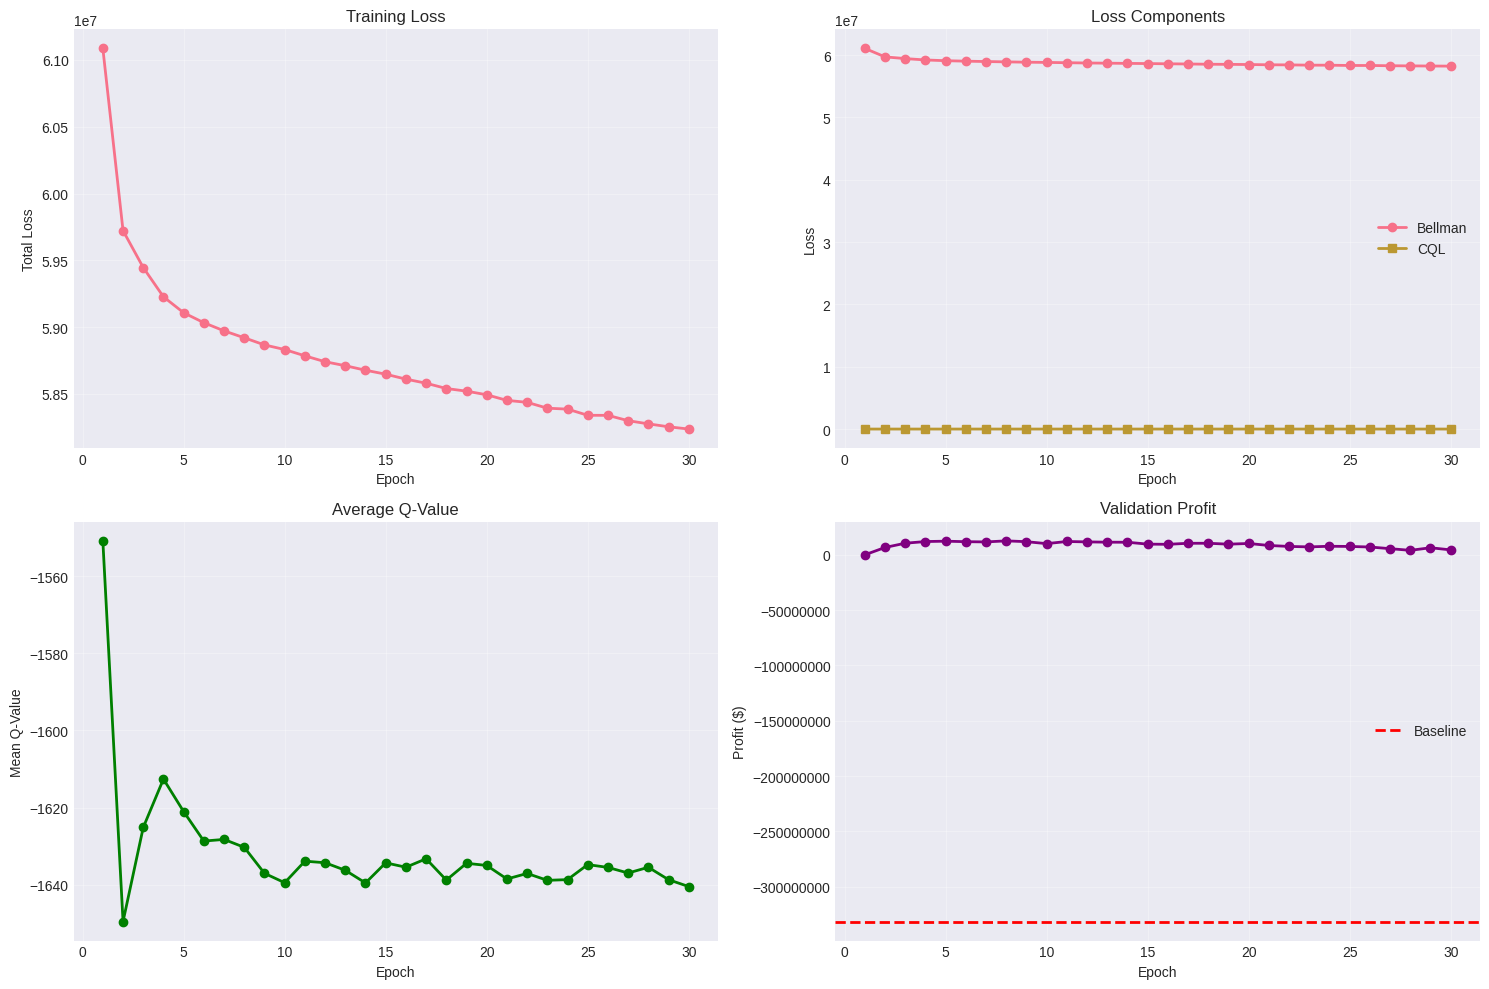


TEST SET:
  Approved: 82,682 (40.97%), Denied: 119,121
  Default rate (approved): 9.56%
  RL Profit: $4,439,418.42
  Baseline: $-333,448,010.06
  Improvement: $337,887,428.49 (+101.33%)


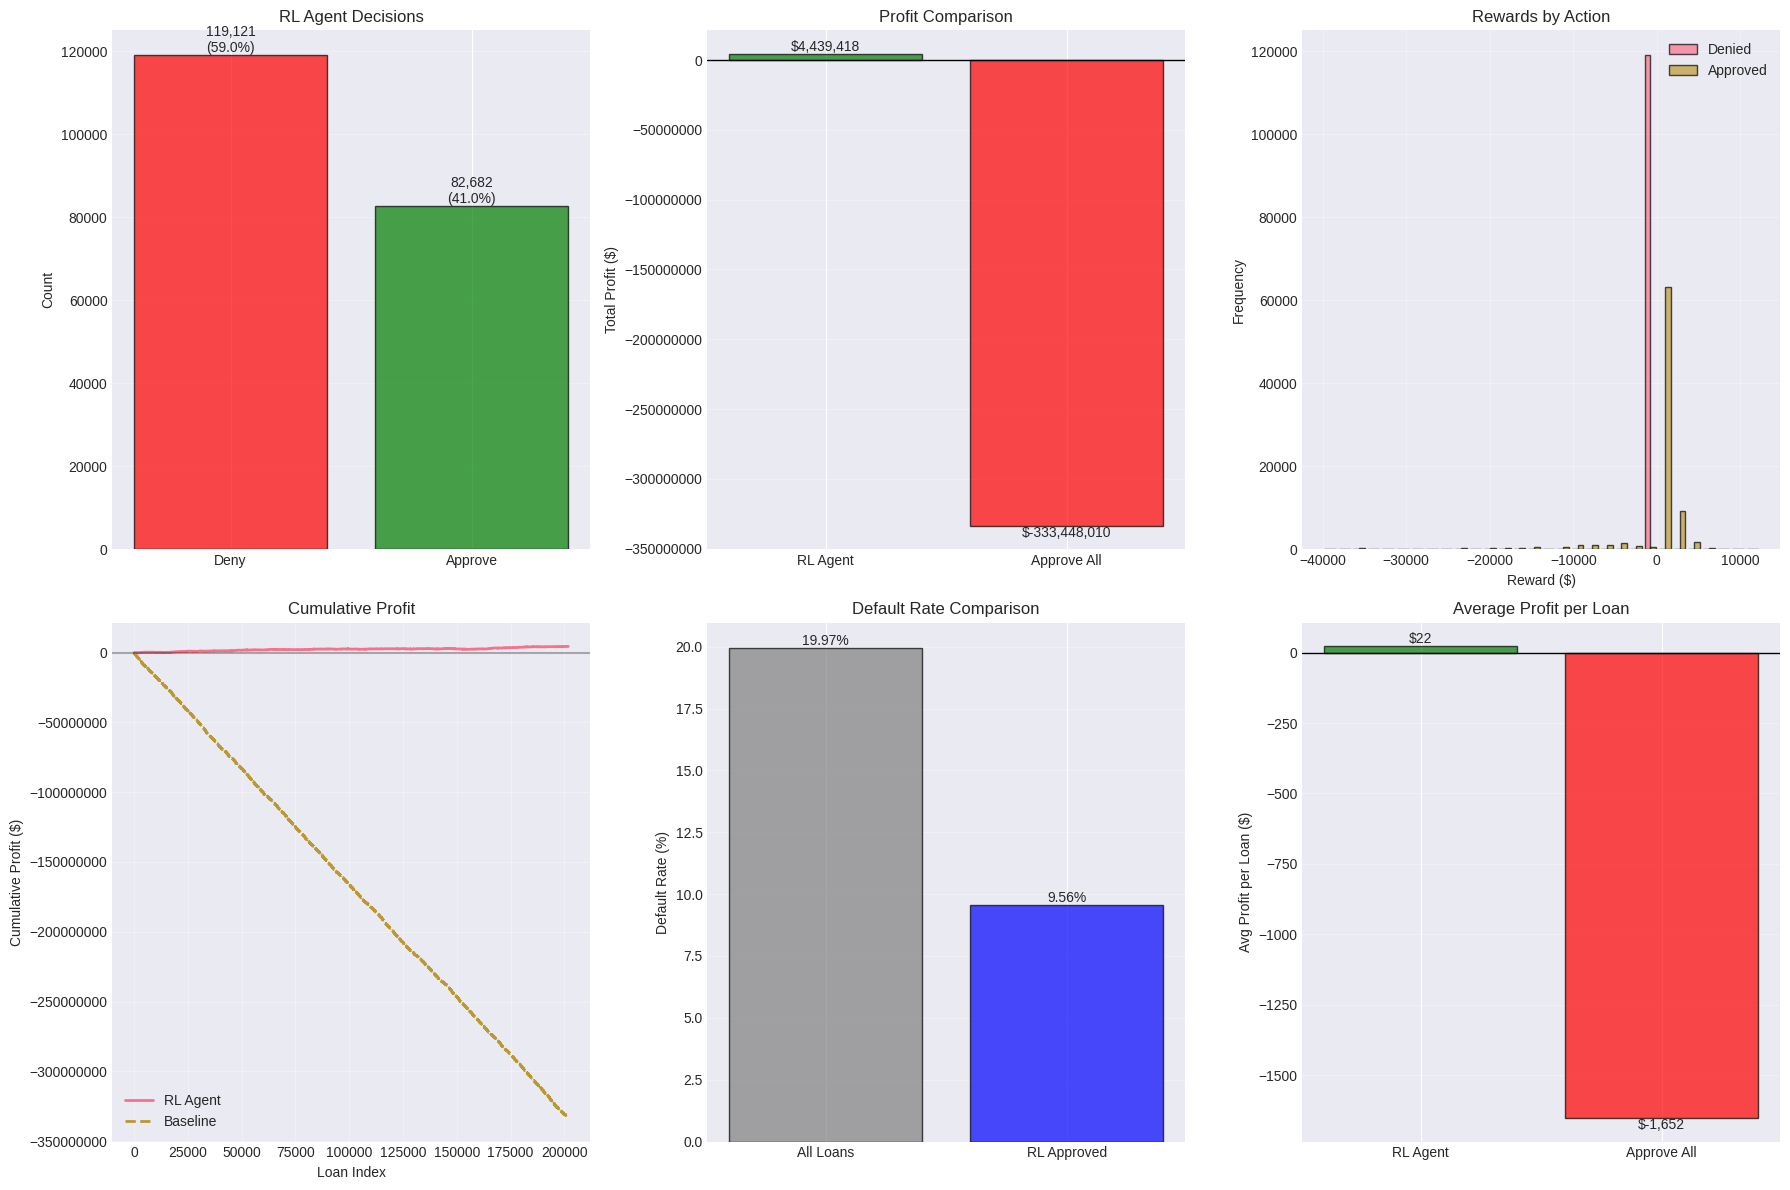


RL AGENT COMPLETE!
✓ Approval rate: 41.0%
✓ Profit improvement: $337,887,428.49
✓ Results saved to 'rl_results.pkl'


In [52]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['epoch'], history['loss'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['epoch'], history['bellman'], marker='o', label='Bellman', linewidth=2)
axes[0, 1].plot(history['epoch'], history['cql'], marker='s', label='CQL', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss Components')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history['epoch'], history['mean_q'], marker='o', linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Mean Q-Value')
axes[1, 0].set_title('Average Q-Value')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history['epoch'], history['val_profit'], marker='o', linewidth=2, color='purple')
axes[1, 1].axhline(rew_val.sum(), color='red', linestyle='--', label='Baseline', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Profit ($)')
axes[1, 1].set_title('Validation Profit')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig('rl_training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


def eval_policy(agent, obs, loans, rates, dflts, name):
    pred_acts = agent.predict(obs)
    pred_rews = calculate_rewards(pred_acts, loans, rates, dflts)
    base_rews = calculate_rewards(np.ones(len(obs), dtype=np.int32), loans, rates, dflts)
    
    n_app = (pred_acts == 1).sum()
    n_den = (pred_acts == 0).sum()
    app_rate = n_app / len(pred_acts)
    
    app_mask = pred_acts == 1
    app_def_rate = dflts[app_mask].mean() if app_mask.sum() > 0 else 0.0
    
    tot_prof = pred_rews.sum()
    base_prof = base_rews.sum()
    improve = tot_prof - base_prof
    
    print(f"\n{name} SET:")
    print(f"  Approved: {n_app:,} ({app_rate*100:.2f}%), Denied: {n_den:,}")
    print(f"  Default rate (approved): {app_def_rate*100:.2f}%")
    print(f"  RL Profit: ${tot_prof:,.2f}")
    print(f"  Baseline: ${base_prof:,.2f}")
    print(f"  Improvement: ${improve:,.2f} ({improve/abs(base_prof)*100:+.2f}%)")
    
    return {
        'actions': pred_acts, 'rewards': pred_rews, 'baseline_rewards': base_rews,
        'approval_rate': app_rate, 'approved_default_rate': app_def_rate,
        'total_profit': tot_prof, 'baseline_profit': base_prof, 'improvement': improve
    }

test_res = eval_policy(agent, obs_test, loan_test, rate_test, def_test, "TEST")

# Performance Visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Actions
act_counts = pd.Series(test_res['actions']).value_counts().sort_index()
axes[0, 0].bar(['Deny', 'Approve'], act_counts.values, alpha=0.7, edgecolor='black', color=['red', 'green'])
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('RL Agent Decisions')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, cnt in enumerate(act_counts.values):
    axes[0, 0].text(i, cnt, f'{cnt:,}\n({cnt/len(test_res["actions"])*100:.1f}%)', ha='center', va='bottom')

# Profit comparison
comp = {'RL Agent': test_res['total_profit'], 'Approve All': test_res['baseline_profit']}
colors = ['green' if v > 0 else 'red' for v in comp.values()]
axes[0, 1].bar(comp.keys(), comp.values(), alpha=0.7, edgecolor='black', color=colors)
axes[0, 1].set_ylabel('Total Profit ($)')
axes[0, 1].set_title('Profit Comparison')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].ticklabel_format(style='plain', axis='y')
for i, (n, v) in enumerate(comp.items()):
    axes[0, 1].text(i, v, f'${v:,.0f}', ha='center', va='bottom' if v > 0 else 'top')

# Reward distribution
app_rews = test_res['rewards'][test_res['actions'] == 1]
den_rews = test_res['rewards'][test_res['actions'] == 0]
axes[0, 2].hist([den_rews, app_rews], bins=30, alpha=0.7, label=['Denied', 'Approved'], edgecolor='black')
axes[0, 2].set_xlabel('Reward ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Rewards by Action')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Cumulative
axes[1, 0].plot(np.cumsum(test_res['rewards']), label='RL Agent', linewidth=2)
axes[1, 0].plot(np.cumsum(test_res['baseline_rewards']), label='Baseline', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Loan Index')
axes[1, 0].set_ylabel('Cumulative Profit ($)')
axes[1, 0].set_title('Cumulative Profit')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].ticklabel_format(style='plain', axis='y')

# Default rates
def_rates = {'All Loans': def_test.mean(), 'RL Approved': test_res['approved_default_rate']}
axes[1, 1].bar(def_rates.keys(), [v*100 for v in def_rates.values()], alpha=0.7, edgecolor='black', color=['gray', 'blue'])
axes[1, 1].set_ylabel('Default Rate (%)')
axes[1, 1].set_title('Default Rate Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, (n, r) in enumerate(def_rates.items()):
    axes[1, 1].text(i, r*100, f'{r*100:.2f}%', ha='center', va='bottom')

# Per-loan profit
per_loan = {'RL Agent': test_res['rewards'].mean(), 'Approve All': test_res['baseline_rewards'].mean()}
colors = ['green' if v > 0 else 'red' for v in per_loan.values()]
axes[1, 2].bar(per_loan.keys(), per_loan.values(), alpha=0.7, edgecolor='black', color=colors)
axes[1, 2].set_ylabel('Avg Profit per Loan ($)')
axes[1, 2].set_title('Average Profit per Loan')
axes[1, 2].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 2].grid(True, alpha=0.3, axis='y')
for i, (n, v) in enumerate(per_loan.items()):
    axes[1, 2].text(i, v, f'${v:,.0f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.savefig('rl_policy_performance.png', dpi=300, bbox_inches='tight')
plt.show()


rl_results = {'test_results': test_res, 'agent': agent, 'history': history}
with open('rl_results.pkl', 'wb') as f:
    pickle.dump(rl_results, f)

print("\n" + "="*80)
print("RL AGENT COMPLETE!")
print("="*80)
print(f"✓ Approval rate: {test_res['approval_rate']*100:.1f}%")
print(f"✓ Profit improvement: ${test_res['improvement']:,.2f}")
print(f"✓ Results saved to 'rl_results.pkl'")
print("="*80)